In [57]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [58]:
class Implementation:
    """
    Stores configuration details for a specific code implementation, 
    device, and execution settings.
    """
    def __init__(self, name: str, device: str, cores: int):
        self.name = name
        self.device = device
        self.cores = cores

    def __repr__(self):
        return (f"Implementation(name='{self.name}', device='{self.device}', "
                f"cores={self.cores})")
    
def get_dataframe(dataset, invariant, implementation_name,
                  num_directions, num_timesteps, device, cores):
    csv_path = f"../results_tempest/{dataset}/{invariant}/{implementation_name}/" + \
        f"{num_directions}_dirs_{num_timesteps}_timesteps_{device}"
    
    if invariant == "ecf":
        csv_path += f"_{cores}_cores"
    
    csv_path += ".csv"

    return pd.read_csv(csv_path)

In [59]:
def plot_speedup_vs_dirs_multitimesteps(
    dataset: str,
    invariant: str,
    timesteps_list: list[int],
    dirs_list: list[int],
    new_impl: Implementation,
    baseline_impl: Implementation,
    show_err_bars: bool = True
):
    """
    Plots speedup = (Baseline time) / (New Implementation time) vs number of directions,
    averaged across all images, with error bars showing dataset variability.
    One speedup curve per timestep value.
    """

    plt.figure(figsize=(10, 6))

    for num_timesteps in timesteps_list:
        mean_speedups = []
        std_speedups = []

        for num_dirs in dirs_list:

            # Load the full dataset for the new implementation
            df_py = get_dataframe(
                dataset, invariant, new_impl.name,
                num_dirs, num_timesteps, new_impl.device, new_impl.cores
            )

            # Load the full dataset for the baseline implementation
            df_eu = get_dataframe(
                dataset, invariant, baseline_impl.name,
                num_dirs, num_timesteps, baseline_impl.device, baseline_impl.cores
            )

            # Check if DataFrames are empty (e.g., if no data was found)
            if df_py.empty or df_eu.empty:
                 print(f"Skipping (dirs={num_dirs}, timesteps={num_timesteps}): Data not found for both implementations.")
                 continue


            # --- Align by image_index (important!) ---
            df = df_py.merge(
                df_eu, on="image_index", 
                suffixes=("_new", "_base")
            )
            
            # Check if alignment resulted in any rows
            if df.empty:
                 print(f"Skipping (dirs={num_dirs}, timesteps={num_timesteps}): No common 'image_index' found after merge.")
                 continue

            # Compute per-image speedups
            # Speedup = Baseline Time / New Implementation Time
            per_image_speedup = df["computation_time_base"] / df["computation_time_new"]

            # Store statistics
            mean_speedups.append(per_image_speedup.mean())
            std_speedups.append(per_image_speedup.std())
            
        # Plot only if we have collected data points
        if mean_speedups:
            # Plot with error bars
            plt.errorbar(
                dirs_list[:len(mean_speedups)], # Ensure dirs_list matches the data collected
                mean_speedups,
                yerr=std_speedups if show_err_bars else None,
                marker="o",
                capsize=4,
                label=f"{num_timesteps} timesteps"
            )

    # Plot a thick line for y=1 (no speedup)
    plt.axhline(y=1, color='r', linestyle='--', linewidth=1)

    plt.xlabel("Number of Directions")
    plt.ylabel(
        f"Avg Speedup ({baseline_impl.name} ({baseline_impl.device}) / "
        f"{new_impl.name} ({new_impl.device}))"
    )
    plt.title(f"Average Speedup vs Number of Directions ({dataset}, {invariant})")
    plt.grid(True)
    plt.legend(title="Timesteps")
    plt.tight_layout()
    plt.show()

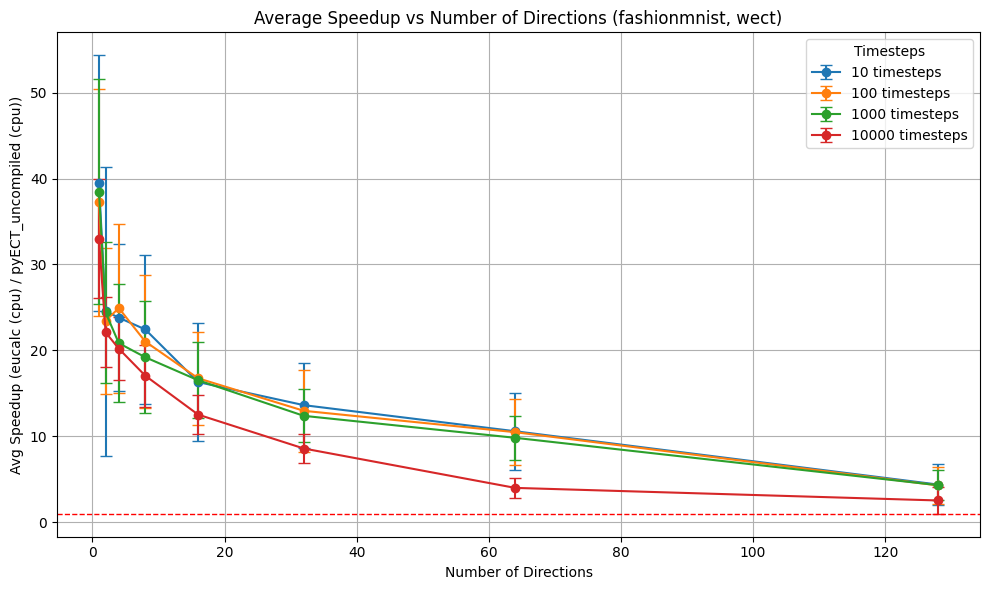

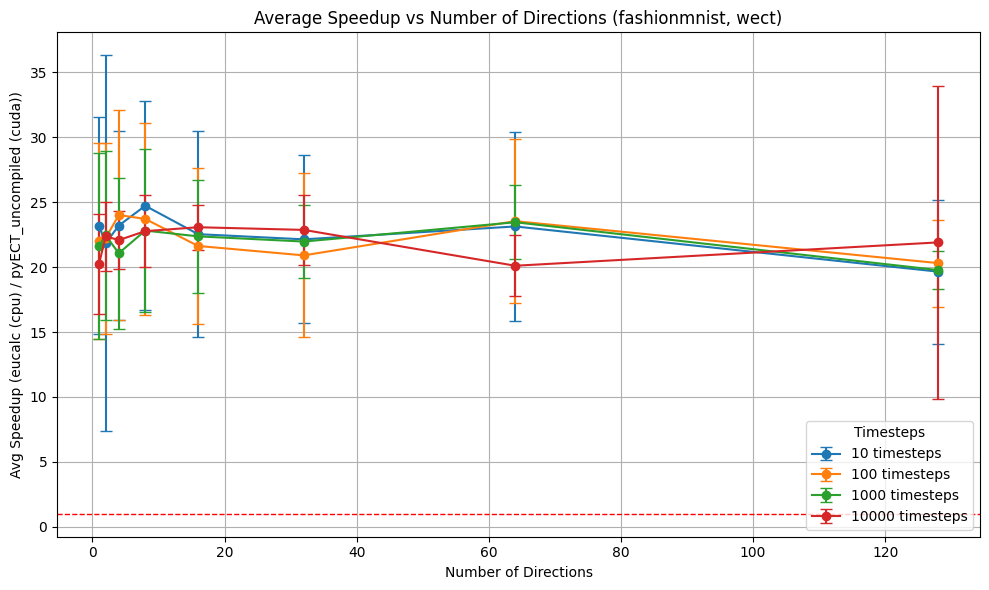

In [60]:
eucalc = Implementation(
    name="eucalc",
    device="cpu",
    cores=1
)

pyECT_uncompiled_cpu = Implementation(
    name="pyECT_uncompiled",
    device="cpu",
    cores=1
)

pyECT_uncompiled_gpu = Implementation(
    name="pyECT_uncompiled",
    device="cuda",
    cores=1
)


plot_speedup_vs_dirs_multitimesteps(
    dataset="fashionmnist",
    invariant="wect",
    timesteps_list=[10, 100, 1000, 10000],
    dirs_list=[1, 2, 4, 8, 16, 32, 64, 128],
    new_impl=pyECT_uncompiled_cpu,
    baseline_impl=eucalc,
    show_err_bars=True
)

plot_speedup_vs_dirs_multitimesteps(
    dataset="fashionmnist",
    invariant="wect",
    timesteps_list=[10, 100, 1000, 10000],
    dirs_list=[1, 2, 4, 8, 16, 32, 64, 128],
    new_impl=pyECT_uncompiled_gpu,
    baseline_impl=eucalc,
    show_err_bars=True
)


In [61]:
class Comparison:
    """
    Stores a pair of Implementation objects to be compared in a single subplot.
    """
    def __init__(self, new_impl: Implementation, baseline_impl: Implementation, include_vectorization_time: bool = False):
        self.new_impl = new_impl
        self.baseline_impl = baseline_impl
        self.include_vectorization_time = include_vectorization_time

    def __repr__(self):
        return (f"Comparison(new={self.new_impl.name}, baseline={self.baseline_impl.name}, include_vectorization_time={self.include_vectorization_time})")

In [62]:
implementation_map = {
    "pyECT_uncompiled": "pyECT",
    "eucalc": "Eucalc",
    "dect": "DECT"
}

device_map = {
    "cpu": "CPU",
    "cuda": "GPU"
}

dataset_map = {
    "fashionmnist": "Fashion-MNIST",
    "imagenet": "ImageNet",
    "bunny": "Bunny",
    "armadillo": "Armadillo"
}

def plot_speedup_panel(
    dataset: str,
    invariant: str,
    timesteps_list: list[int],
    dirs_list: list[int],
    comparisons_list: list[Comparison],
    grid_shape: tuple[int, int],
    show_err_bars: bool = True,
    fix_axes: bool = True,
    log_scale: bool = False
):
    """
    Creates a panel of speedup plots based on a list of specified comparisons.

    Args:
        dataset (str): The name of the dataset used.
        invariant (str): The name of the invariant being measured.
        timesteps_list (list[int]): List of timestep values to plot.
        dirs_list (list[int]): List of direction values (x-axis).
        comparisons_list (list[Comparison]): List of Comparison objects 
                                             defining each subplot's content.
        grid_shape (tuple[int, int]): (rows, columns) for the subplot grid.
        show_err_bars (bool): Whether to display error bars (std deviation).
        fix_axes (bool): If True, all subplots share the same Y-axis scale 
                         (sharey=True). If False, each subplot sets its own 
                         Y-axis scale (sharey=False).
        log_scale (bool): If True, set Y-axis to logarithmic scale.
    """

    num_rows, num_cols = grid_shape
    num_plots = num_rows * num_cols

    if len(comparisons_list) > num_plots:
        print(f"Warning: {len(comparisons_list)} comparisons provided, but grid only fits {num_plots}. Excess comparisons will be ignored.")
        comparisons_list = comparisons_list[:num_plots]
    elif len(comparisons_list) < num_plots:
        print(f"Note: Grid size is {num_plots}, but only {len(comparisons_list)} comparisons provided.")


    # Create the figure and all subplots
    # Set sharey based on the fix_axes parameter
    fig, axes = plt.subplots(num_rows, num_cols, 
                             figsize=(7 * num_cols, 4 * num_rows), 
                             sharex=True, 
                             sharey=fix_axes)
    
    # Flatten the axes array for easy iteration
    if num_rows == 1 and num_cols == 1:
        axes = np.array([axes])
    elif num_rows == 1 or num_cols == 1:
        axes = axes.flatten()
    else:
        axes = axes.flatten()
    
    # Loop through all comparisons and plot on their respective subplots
    for ax_idx, comparison in enumerate(comparisons_list):
        ax = axes[ax_idx]
        new_impl = comparison.new_impl
        baseline_impl = comparison.baseline_impl

        # --- Subplot Logic (Unchanged) ---
        
        for num_timesteps in timesteps_list:
            mean_speedups = []
            std_speedups = []

            for num_dirs in dirs_list:
                # Load data for new implementation
                df_new = get_dataframe(
                    dataset, invariant, new_impl.name,
                    num_dirs, num_timesteps, new_impl.device, new_impl.cores
                )

                # Load data for baseline implementation
                df_base = get_dataframe(
                    dataset, invariant, baseline_impl.name,
                    num_dirs, num_timesteps, baseline_impl.device, baseline_impl.cores
                )

                # Alignment and Speedup Calculation
                if df_new.empty or df_base.empty:
                    # Skip if data is missing for either
                    continue

                df = df_new.merge(
                    df_base, on="image_index", 
                    suffixes=("_new", "_base")
                )
                
                if not df.empty:
                    # Speedup = Baseline Time / New Implementation Time
                    if comparison.include_vectorization_time:
                        per_image_speedup = (df["computation_time_base"] + df["vectorization_time_base"]) / \
                                            (df["computation_time_new"] + df["vectorization_time_new"])
                    else:
                        per_image_speedup = df["computation_time_base"] / df["computation_time_new"]

                    mean_speedups.append(per_image_speedup.mean())
                    std_speedups.append(per_image_speedup.std())

            # Plot with error bars on the current axis
            if mean_speedups:
                ax.errorbar(
                    dirs_list[:len(mean_speedups)],
                    mean_speedups,
                    yerr=std_speedups if show_err_bars else None,
                    marker="o",
                    capsize=4,
                    label=f"{num_timesteps}"
                )

        # --- Subplot Formatting (Unchanged) ---
        
        # Plot y=1 line
        ax.axhline(y=1, color='r', linestyle='--', linewidth=1, alpha=0.7)
        
        # Set titles and labels
        ax.set_title(f"{dataset_map[dataset]}: {implementation_map[baseline_impl.name]}{' + vectorization' if comparison.include_vectorization_time else ''} ({device_map[baseline_impl.device]}) vs {implementation_map[new_impl.name]} ({device_map[new_impl.device]})", 
                     fontsize=14)
        
        # Only label the Y-axis if fix_axes is False (or on the first column if True)
        if ax_idx % num_cols == 0:
             ax.set_ylabel("Avg Speedup", fontsize=12)
             
        ax.set_xlabel("Number of Directions", fontsize=12)
        ax.grid(True, linestyle=':', alpha=0.6)
        ax.legend(title="NumVals", fontsize=11, title_fontsize=12)
        ax.tick_params(labelsize=12)

        if log_scale:
            ax.set_yscale('log')


    # Hide any unused subplots
    for i in range(len(comparisons_list), num_plots):
        fig.delaxes(axes[i])
        
    # Ensure proper spacing between subplots
    plt.tight_layout(rect=[0, 0, 1, 0.98])
    plt.savefig(f"figs/{invariant}_{dataset}_{'_'.join([str(c).replace(' ', '') for c in comparisons_list])}.pdf")
    plt.show()

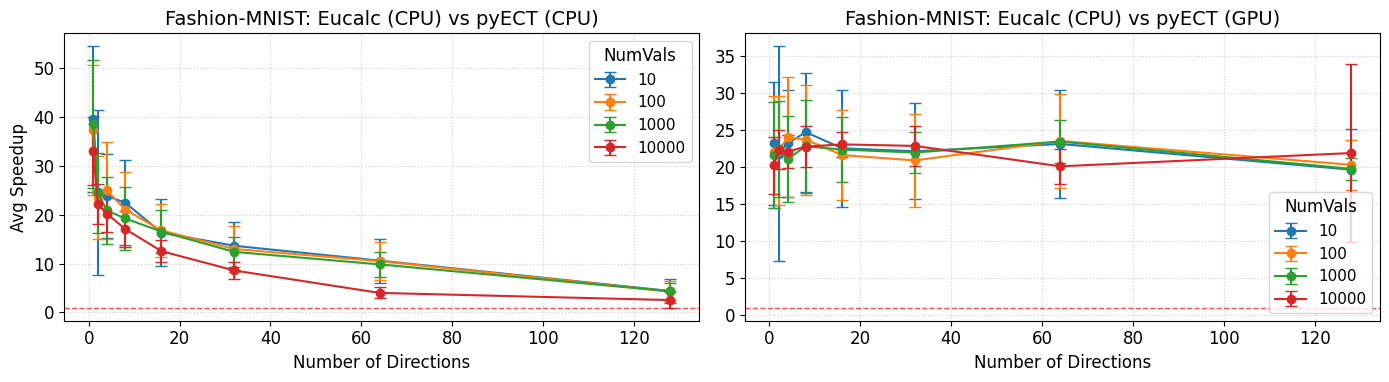

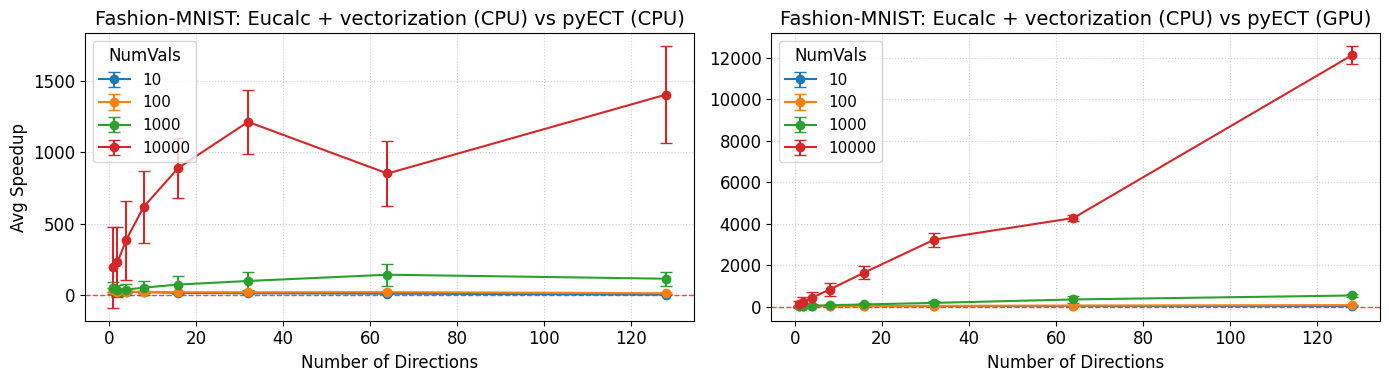

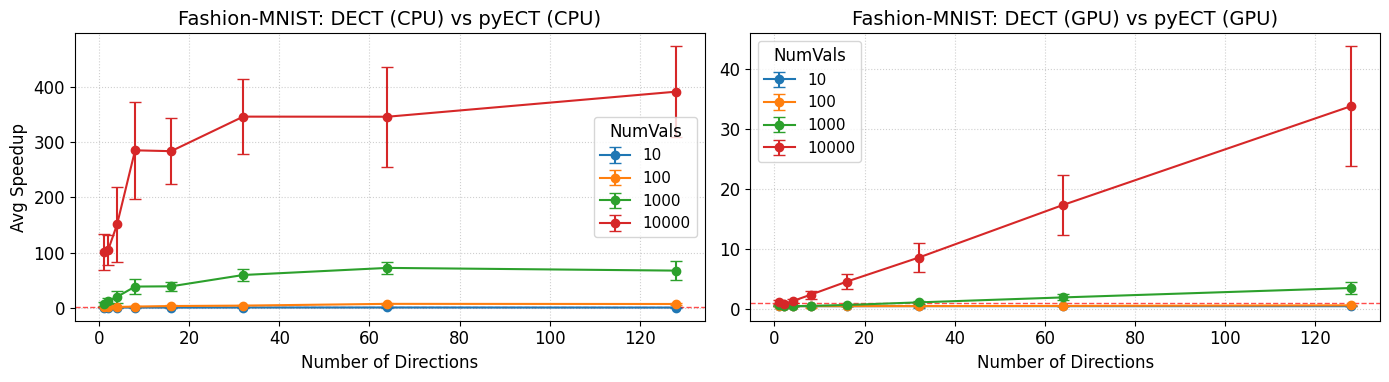

In [63]:

# 1. Define all possible implementations
eucalc = Implementation(name="eucalc", device="cpu", cores=1)
pyECT_uncompiled_cpu = Implementation(name="pyECT_uncompiled", device="cpu", cores=1)
pyECT_uncompiled_gpu = Implementation(name="pyECT_uncompiled", device="cuda", cores=1)
dect_cpu = Implementation(name="dect", device="cpu", cores=1)
dect_gpu = Implementation(name="dect", device="cuda", cores=1)


comparison1 = [
    Comparison(new_impl=pyECT_uncompiled_cpu, baseline_impl=eucalc), 
    Comparison(new_impl=pyECT_uncompiled_gpu, baseline_impl=eucalc),
]

comparison2 = [
    Comparison(new_impl=pyECT_uncompiled_cpu, baseline_impl=eucalc, include_vectorization_time=True), 
    Comparison(new_impl=pyECT_uncompiled_gpu, baseline_impl=eucalc, include_vectorization_time=True),
]

comparison3 = [
    Comparison(new_impl=pyECT_uncompiled_cpu, baseline_impl=dect_cpu), 
    Comparison(new_impl=pyECT_uncompiled_gpu, baseline_impl=dect_gpu)
]

grid_shape = (1, 2) # 1 row, 2 columns
data_set = "fashionmnist"
invariant = "wect"
timesteps_list = [10, 100, 1000, 10000]
dirs_list = [1, 2, 4, 8, 16, 32, 64, 128]

plot_speedup_panel(
    data_set,
    invariant,
    timesteps_list,
    dirs_list,
    comparison1,
    grid_shape,
    fix_axes=False
)

plot_speedup_panel(
    data_set,
    invariant,
    timesteps_list,
    dirs_list,
    comparison2,
    grid_shape,
    fix_axes=False
)

plot_speedup_panel(
    data_set,
    invariant,
    timesteps_list,
    dirs_list,
    comparison3,
    grid_shape,
    fix_axes=False
)

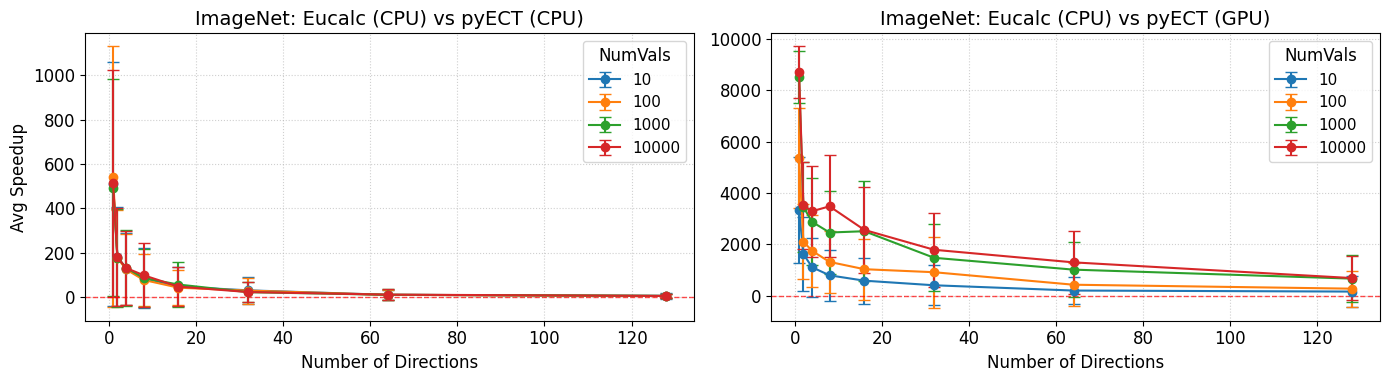

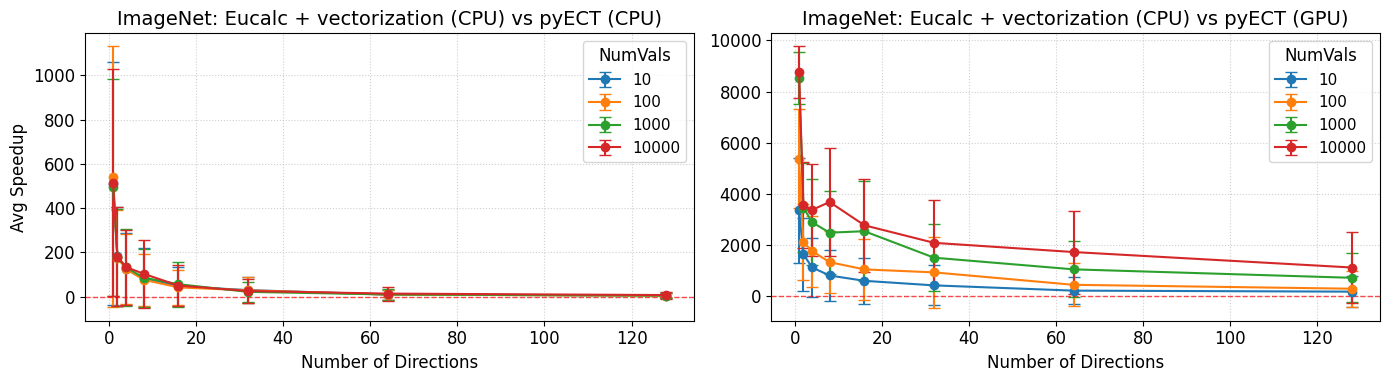

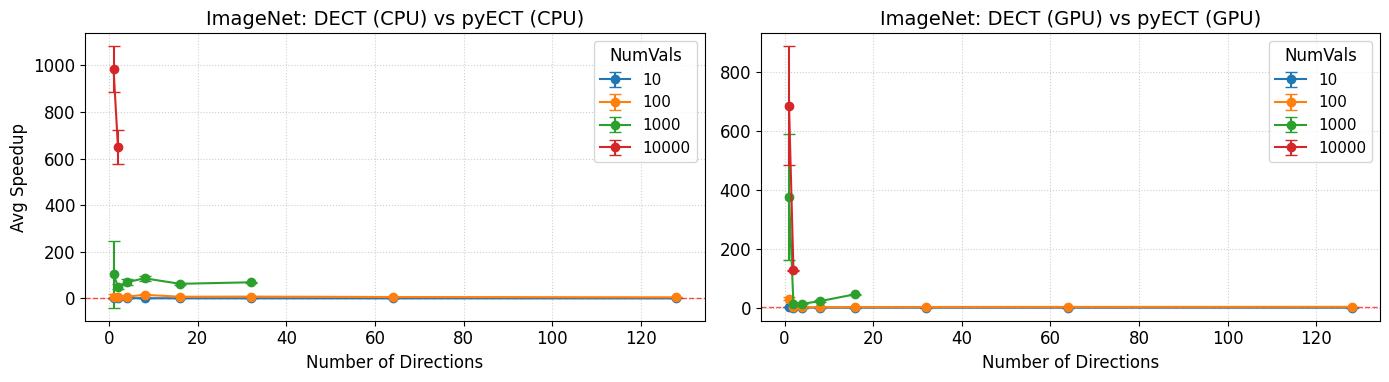

In [64]:
comparison1 = [
    Comparison(new_impl=pyECT_uncompiled_cpu, baseline_impl=eucalc), 
    Comparison(new_impl=pyECT_uncompiled_gpu, baseline_impl=eucalc),
]

comparison2 = [
    Comparison(new_impl=pyECT_uncompiled_cpu, baseline_impl=eucalc, include_vectorization_time=True), 
    Comparison(new_impl=pyECT_uncompiled_gpu, baseline_impl=eucalc, include_vectorization_time=True),
]

comparison3 = [
    Comparison(new_impl=pyECT_uncompiled_cpu, baseline_impl=dect_cpu),
    Comparison(new_impl=pyECT_uncompiled_gpu, baseline_impl=dect_gpu)
]

grid_shape = (1, 2) # 1 row, 2 columns
data_set = "imagenet"
invariant = "wect"
timesteps_list = [10, 100, 1000, 10000]
dirs_list = [1, 2, 4, 8, 16, 32, 64, 128]

plot_speedup_panel(
    data_set,
    invariant,
    timesteps_list,
    dirs_list,
    comparison1,
    grid_shape,
    fix_axes=False,
    log_scale=False
)

plot_speedup_panel(
    data_set,
    invariant,
    timesteps_list,
    dirs_list,
    comparison2,
    grid_shape,
    fix_axes=False,
    log_scale=False
)

plot_speedup_panel(
    data_set,
    invariant,
    timesteps_list,
    dirs_list,
    comparison3,
    grid_shape,
    fix_axes=False,
    log_scale=False
)

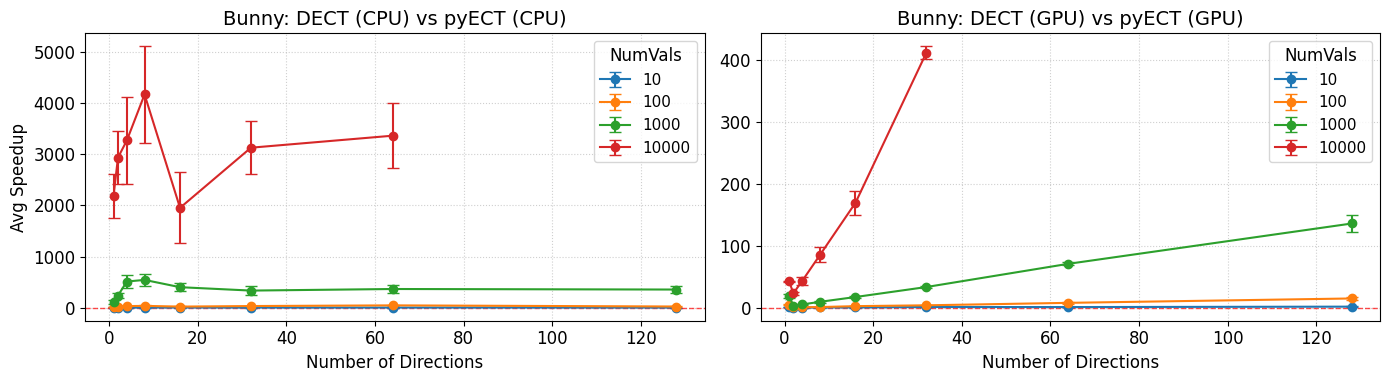

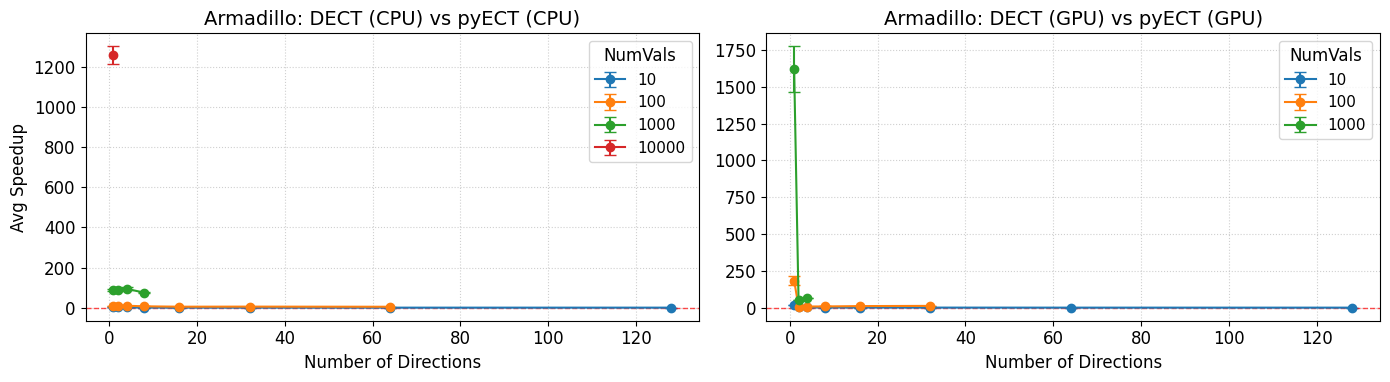

In [65]:
comparison = [
    Comparison(new_impl=pyECT_uncompiled_cpu, baseline_impl=dect_cpu), 
    Comparison(new_impl=pyECT_uncompiled_gpu, baseline_impl=dect_gpu),
]

grid_shape = (1, 2) # 1 row, 2 columns
data_set1, data_set2 = "bunny", "armadillo"
invariant = "wect"
timesteps_list = [10, 100, 1000, 10000]
dirs_list = [1, 2, 4, 8, 16, 32, 64, 128]

plot_speedup_panel(
    data_set1,
    invariant,
    timesteps_list,
    dirs_list,
    comparison,
    grid_shape,
    fix_axes=False,
    log_scale=False
)

plot_speedup_panel(
    data_set2,
    invariant,
    timesteps_list,
    dirs_list,
    comparison,
    grid_shape,
    fix_axes=False,
    log_scale=False
)